In [1]:
from __future__ import division
import scipy.stats as ss
from collections import defaultdict
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline
from collections import Counter
import heapq
import multiprocessing as mp
import time 
import gc
gc.enable()
gc.collect()


0

In [2]:
# def ts_policy(arms, time, num_sampling, num_process, alpha=1, beta=0.1):

def ts_policy(arms, times, num_sampling, get_reward, no_reward, num_process, alpha=1, beta=0.1):
#     arms, times, num_sampling = 100,1000,1000
    #プレイされたラウンド分の腕ごとの報酬、reward_lisを格納
    history_reward = []
    #表示された腕、arm_lisを格納
    history_arm = []
    #各ラウンドでの最大クリック回数、ポアソン分布(mu=1)に従うと仮定
    play_limit = []
    #play_limitが与えられた前提での最大報酬、高いものから引かれる前提
    ideal_rewards = []
    #１ラウンド中の合計報酬
    num_reward = []    
    
    #50万回実施のパラメータは固定で与えてあげる
    gr = get_reward
    nr = no_reward
    
    print("trial start")
    print("this time trial rewards",gr)
    print("this time given rewards",get_reward)
    print("this time trial failures",nr)
    print("this time given failures",no_reward)
    
    #上記２種のリストをthompson sampling計算用のパラメータに直したバージョン
    adjusted_reward = np.zeros(arms)
    adjusted_no_reward = np.zeros(arms)        
    #各腕ごとに異なる標準偏差を持っている
    sd = (np.random.rand(100,)/100).tolist()
    
#     proc = num_process
    #multiprocess対応するため、作業範囲を切っておく
    ini = times * num_process // proc
    fin = times * (num_process+1) // proc
    print("",ini)
    print(fin)

    for t in range(ini, fin):
        #TSした時の報酬を格納しておく場所
        mu = np.zeros(arms)
        for k in range(arms):
            #パラメータの上限を設定しておかないと、特定の腕だけが飛び抜けて選択されるようになる
            #上限に達した後は、1000の中で按分するようにすればうまくいくのでは？
            played = gr[k]+nr[k]
            if played >1000:
                adjusted_reward[k] = (gr[k]/played)*1000
                adjusted_no_reward[k] = (nr[k]/played)*1000
            else:
                adjusted_reward[k] = gr[k]
                adjusted_no_reward[k] = nr[k]
                
            #ベータ分布の形をした報酬から報酬をピックアップする
            mu[k] = np.random.beta((adjusted_reward[k]+1)+alpha, (adjusted_no_reward[k]+1)+1, size=num_sampling).sum()
        #報酬の最も高い中で10個の腕が選択される(zexy仕様)
        pulling_arm = np.array(mu).argsort()[-10:][::-1]
        
        #腕をプレイして報酬を確認、1ならget_rewardに+1、0ならno_rewardに+1
        #実際には100で割るんでなくて、1000~10000くらいで割るのが現実的
        #1~3までの分布があるものを想定して、そこまでは通常通り実施、あとは報酬0にする
        #平均1のポアソン分布に従うプレイ回数とする
        limit = ss.poisson.rvs(1)
        play_limit.append(limit)
        play_per_person = 0
        im = list(range(100))
        ideal_reward = 0.05*limit - sum(im[:limit])*0.0005
        ideal_rewards.append(ideal_reward)
        #確率が高いものから選択される、という仮定を置いているが、今のケースだとこれが限界
        #contextualを入れればそこはよしなに出しわけ可能
        #CTRベースの計算なので、CVRをターゲットとするときはrewardのmaxを1に変える必要ある

        #１ラウンド中、腕ごとの報酬
        reward_lis = []
        for pa in pulling_arm:
            if limit > play_per_person:
                #腕の報酬部分を設定、max5%~min0.05%、0.05%刻みの100種類
                prob = min(abs(np.random.normal((pa+1)/2000,sd[pa])),1)
                reward = np.random.choice([0, 1], p=[(1-prob), prob])
                #multiでクリックされる想定、複数クリックがあれば複数更新される
                #択一のケースも想定する必要あり
                if reward ==1:
                    get_reward[pa] +=1
                else:
                    no_reward[pa] +=1
                reward_lis.append(reward)
            else:
                reward_lis.append(0)
                no_reward[pa] +=1
            play_per_person +=1
                
            #１人がプレイする上限回数に達したら、残りの報酬は０
            
        #history、結果の保持
        #腕ごと報酬
        history_reward.append(reward_lis)
        #ラウンドの報酬
        num_reward.append(sum(reward_lis))
        #プレイされた腕
        history_arm.append(pulling_arm)
#         #パラメータ調整
        
        
    return [get_reward, no_reward,get_reward+no_reward, history_reward, history_arm,play_limit,ideal_rewards,num_reward]


In [3]:
start=time.time()
#     arms, time, num_sampling = 100,1000,1000
cores = 4
proc = cores
pool = mp.Pool(proc)
# ts_policy(arms, time, num_sampling, num_process, alpha=1, beta=0.1):
# callback = pool.map(ts_policy(100,1000,1000,range(4)), range(4))
callback = pool.map(ts_policy, range(cores))
end = time.time()
taken_time = end - start
print(taken_time)

# return callback

#callbackの中身は
# get_reward, no_reward,get_reward+no_reward, history_reward, history_arm,play_limit,ideal_rewards,num_reward

1.0686237812042236


In [3]:
def wrapper_hiki(tuples):
    return tuples[0](tuples[1],tuples[2],tuples[3],tuples[4],tuples[5],tuples[6])

def distributed_offline_mab_ts(arms, times, num_sampling, get_reward, no_reward, cores):
    start=time.time()
    #mapで渡せる引数は1つしかないので、tupleを使って与える必要がある
    hiki = [(ts_policy, arms, times, num_sampling, get_reward, no_reward, i) for i in range(cores)]

    callback = pool.map(wrapper_hiki, hiki)
    end = time.time()
    taken_time = end - start
    print(taken_time)
    
    return callback

    #callbackの中身は
    # get_reward, no_reward,get_reward+no_reward, history_reward, history_arm,play_limit,ideal_rewards,num_reward

In [15]:
cores = 4
proc = cores
pool = mp.Pool(proc) #ここの２行は外に出す必要がある
# callback = distributed_offline_mab_ts(100,100,1000,np.zeros(100),np.zeros(100),cores)
callback = distributed_offline_mab_ts(100,100,1000,get_reward, no_reward,cores)


trial start
trial start
trial start
this time trial rewards [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
trial start
this time trial rewards [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]this time trial rewards [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

In [26]:
print(callback[0][0])
print(sum(callback[0][1]))
print(callback[0][1])
print(callback[0][4])
print(callback[1][4])



[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1246.0
[ 12.  12.  13.  12.  12.  12.  12.  12.  12.  12.  12.  13.  13.  13.  12.
  12.  12.  12.  13.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.
  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  13.
  40.  12.  12.  12.  12.  12.  12.  13.  12.  13.  12.  13.  13.  12.  12.
  12.  12.  13.  12.  12.  12.  12.  12.  12.  12.  13.  12.  13.  12.  13.
  13.  12.  13.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  12.  13.
  12.  12.  12.  12.  12.  12.  12.  12.  13.  12.]
[array([45, 47, 42,  4, 26, 85, 55, 84, 78, 44]), array([45, 77, 51, 14, 56, 6

In [14]:
#coresの分だけ結果が分散されて出力されるので、アップデートは気を使う必要あり
#１つ目でcores、２つ目で結果指定
#updateに使うのはget_rewardの値を全て足したものとno_rewardを足したもの
#callback 0,1は合計する
#callback 3,4,5,6,7はそのままappend
arms = 100
times = 100
num_sampling = 1000
cores = 4
proc = cores
pool = mp.Pool(proc) #ここはループの外に出す必要がある。ループ内にあるとfileをPool時にファイルを開きまくって、ファイル開きすぎエラーが出る

for i in range(1):
    #TSの実施
#     print("i",i)
#     try:
#         get_reward, no_reward
#     except:
#         #腕ごとの報酬を獲得した/しなかった回数を記録
#         get_reward = np.zeros(arms).tolist()
#         no_reward = np.zeros(arms).tolist()
    print(i)
    if i ==0:
        get_reward = np.zeros(arms).tolist()
        no_reward = np.zeros(arms).tolist()

    callback = distributed_offline_mab_ts(arms, times, num_sampling, get_reward, no_reward, cores)
    success = np.zeros(100)
    failure = np.zeros(100)

    #結果の受け皿を作る
    for cl in range(cores):
#         print("cl",cl)
        success += callback[cl][0]
        failure += callback[cl][1]
#         print(i)
        print(cl)
        if cl ==0:
#             history_reward = np.array(callback[cl][3])
            history_reward = callback[cl][3]
            history_arm = [cb.tolist() for cb in callback[cl][4]]
            play_limit = callback[cl][5]
            ideal_rewards = callback[cl][6]
            num_reward = callback[cl][7]
        else:
            history_reward.extend(callback[cl][3])
            history_arm.extend([cb.tolist() for cb in callback[cl][4]])
            play_limit.extend(callback[cl][5])
            ideal_rewards.extend(callback[cl][6])
            num_reward.extend(callback[cl][7])

    if i ==0:
        get_reward = success
        no_reward = failure
        history_reward_big = history_reward
        history_arm_big = history_arm
        play_limit_big = play_limit
        ideal_rewards_big = ideal_rewards
        num_reward_big = num_reward
    else:
#         num_reward_big = np.vstack((num_reward_big, history_reward))
        get_reward += success
        no_reward += failure
        history_reward_big.extend(history_reward)
        history_arm_big.extend(history_arm)
        play_limit_big.extend(play_limit)
        ideal_rewards_big.extend(ideal_rewards)
        num_reward_big.extend(num_reward)
        
#     history_reward, history_arm, play_limit, ideal_rewards, num_reward, get_reward, no_reward


trial start
trial start
trial start
trial start
this time trial rewards [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
this time trial rewards [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.

In [5]:
# len(callback[0][7])
# len(callback[cl][3])
# kk = callback[cl][3]

# history_reward_big #要対応
# history_arm_big #○
# play_limit_big #○
# ideal_rewards_big #○
# num_reward_big #要対応
# success_big
# failure_big

print(len(history_reward_big))
print(len(history_arm_big))
print(len(play_limit_big))
print(len(ideal_rewards_big))
print(len(num_reward_big))
print(len(get_reward))
print(len(no_reward))
# np.array(history_arm_big).flatten()
# get_reward
# callback[cl][3]
# num_reward
# num_reward_big

400
400
400
400
400
100
100


In [6]:
print("試行回数",len(history_reward_big))
print("クリック回数",sum(play_limit_big))
print("理想値",sum(ideal_rewards_big))
print("実績値",sum(num_reward_big))
print("報酬分布",get_reward)
print("報酬総数",sum(get_reward))
print("失敗分布",no_reward)
print("失敗総数",sum(no_reward))

試行回数 400
クリック回数 428
理想値 21.272000000000045
実績値 12
報酬分布 [   0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.  500.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.
    0.    0.    0.    0.    0.    0.    0.    0.    0.    0.  120.    0.
    0.    0.    0.    0.]
報酬総数 620.0
失敗分布 [ 1540.  1492.  1488.  1528.  1488.  1600.  1496.  1524.  1488.  1508.
  1520.  1508.  1524.  1504.  1488.  1504.  1600.  1520.  1600.  1492.
  1600.  1492.  1500.  1504.  1524.  1504.  1484.  1524.  1504.  1600.
  1504.  1488.  1508.  1524.  1524.  1520.  1496.  1504.  1500.  1496.
  1504.  1504.  1488.  1520.  1492.

In [13]:
# success
callback[cl][0]
print(callback[3][1])
print(callback[2][1])


[ 308.  299.  298.  306.  298.  320.  300.  305.  298.  302.  304.  302.
  305.  301.  299.  301.  320.  304.  320.  299.  320.  299.  300.  302.
  305.  301.  297.  305.  301.  320.  301.  298.  302.  305.  305.  304.
  300.  301.  300.  301.  302.  301.  298.  304.  299.  985.  304.  300.
  301.  320.  320.  304.  297.  300.  302.  298.  297.  320.  300.  299.
  301.  320.  299.  297.  301.  302.  299.  299.  301.  306.  303.  300.
  301.  301.  303.  304.  303.  299.  300.  298.  302.  297.  302.  299.
  299.  301.  304.  301.  299.  320.  302.  305.  320.  299.  421.  301.
  304.  306.  298.  302.]
[ 308.  299.  298.  306.  298.  320.  300.  305.  298.  302.  304.  302.
  305.  301.  299.  301.  320.  304.  320.  299.  320.  299.  300.  302.
  305.  301.  297.  305.  301.  320.  301.  298.  302.  305.  305.  304.
  300.  301.  300.  301.  302.  301.  298.  304.  299.  985.  304.  300.
  301.  320.  320.  304.  297.  300.  302.  298.  297.  320.  300.  299.
  301.  320.  299.  297. 

In [50]:
# print(sum(num_reward_big[:100000]))
# print(sum(num_reward_big[100000:200000]))
# print(sum(num_reward_big[200000:300000]))
print(get_reward[:1000])

4212
3836
4232
trial is [    0.     0.     0.     0.     0.     0.     0.     0.     0.     4.
     0.     0.     0.     0.     4.     0.     4.     0.     0.     0.
     0.     0.     4.     8.     0.     0.     0.     0.     0.    20.
     4.     0.     0.     4.     0.     0.     0.     0.     0.    16.
     0.    20.     4.    20.     0.     0.     0.     4.     0.     0.
     0.    56.     4.   208.     4.    16.    32.     4.    20.     4.
     0.     4.     4.     4.     4.     0.     0.     0.     0.     0.
    12.     0.     4.     4.     4.   232.     8.  2320.     4.    24.
     0.  2640.    12.     0.    12.    12.  1104.  1000.  2720.    12.
  1076.     8.     0.     8.   100.     0.   380.    16.    16.    72.]


In [57]:
history_reward_big[1]
history_arm_big[:100]

[[59, 46, 97, 4, 71, 67, 87, 94, 54, 90],
 [2, 33, 43, 6, 11, 7, 96, 45, 80, 64],
 [84, 79, 30, 3, 38, 56, 25, 85, 15, 21],
 [84, 24, 92, 29, 70, 93, 10, 65, 73, 9],
 [74, 78, 34, 26, 13, 32, 23, 75, 0, 16],
 [95, 17, 66, 31, 8, 77, 68, 62, 50, 72],
 [42, 57, 1, 20, 18, 86, 22, 52, 27, 63],
 [49, 89, 14, 98, 47, 76, 51, 44, 35, 41],
 [40, 19, 60, 5, 99, 48, 84, 28, 58, 88],
 [39, 36, 61, 69, 53, 12, 37, 55, 83, 82],
 [91, 81, 84, 28, 33, 53, 57, 76, 2, 93],
 [5, 98, 24, 12, 22, 96, 51, 7, 56, 48],
 [71, 66, 3, 11, 43, 83, 86, 60, 82, 17],
 [27, 74, 25, 91, 6, 37, 81, 95, 99, 52],
 [49, 18, 1, 15, 46, 35, 42, 10, 21, 89],
 [63, 26, 65, 90, 19, 97, 29, 78, 87, 20],
 [92, 77, 9, 69, 23, 55, 16, 36, 80, 39],
 [64, 79, 4, 44, 67, 61, 75, 40, 73, 72],
 [41, 47, 31, 8, 14, 30, 59, 62, 70, 88],
 [68, 13, 58, 34, 0, 85, 50, 38, 54, 32],
 [45, 94, 84, 0, 56, 67, 47, 34, 26, 86],
 [61, 65, 60, 43, 1, 31, 45, 42, 8, 59],
 [2, 93, 88, 41, 15, 28, 99, 10, 80, 33],
 [52, 27, 16, 40, 66, 98, 90, 95, 5

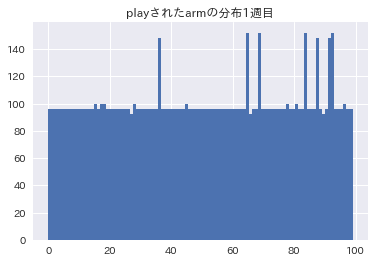

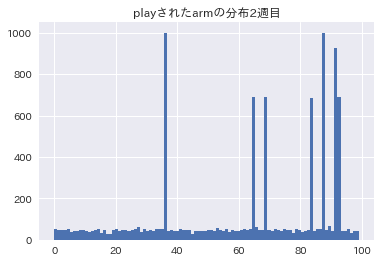

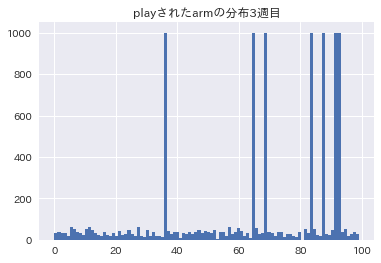

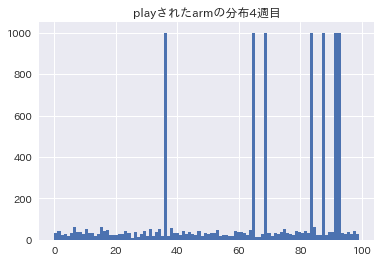

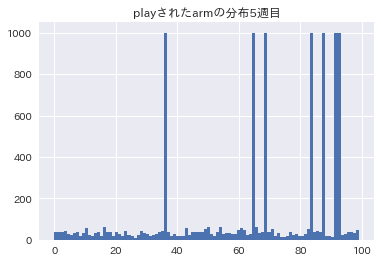

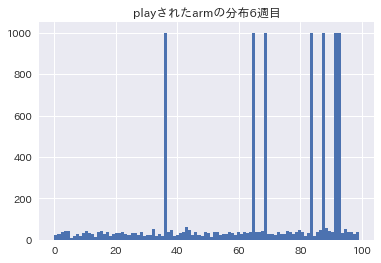

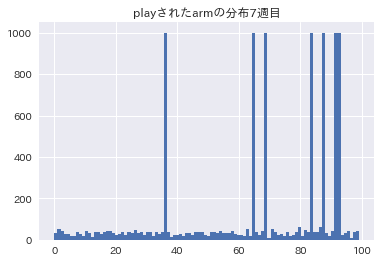

In [39]:
for i in range (7):
    mn = i*1000
    mx = mn+1000
    plt.hist(np.array(history_arm_big[mn:mx]).flatten(),bins=100)
    titles = "playされたarmの分布"+str(i+1)+"週目"
    plt.title(titles)
    plt.show()


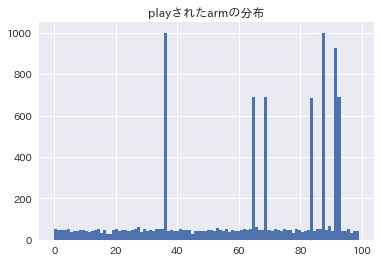

In [32]:
plt.hist(np.array(history_arm_big[1000:2000]).flatten(),bins=100)
plt.title("playされたarmの分布")
plt.show()


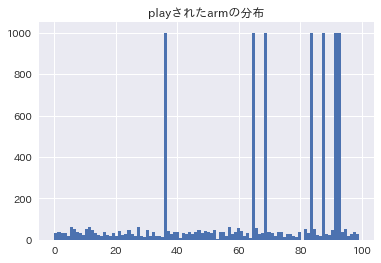

In [33]:
plt.hist(np.array(history_arm_big[2000:3000]).flatten(),bins=100)
plt.title("playされたarmの分布")
plt.show()


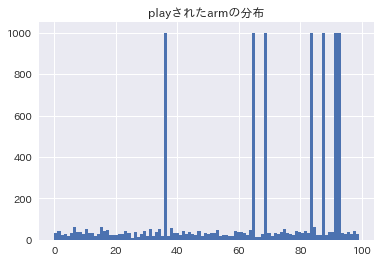

In [34]:
plt.hist(np.array(history_arm_big[3000:4000]).flatten(),bins=100)
plt.title("playされたarmの分布")
plt.show()


In [59]:
# num_reward.shape
# np.array(callback[cl][7])
# num_reward.flatten()
callback[3][5]
num_reward.flatten()
num_reward
aa = np.vstack((np.array(callback[cl][7]).flatten(), np.array(callback[cl][7]).flatten()))
aa

array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0]])

In [60]:
np.vstack((aa, np.array(callback[cl][7]).flatten()))


array([[0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
        0, 0, 0]])

In [65]:
# # len(np.array(history_reward).flatten())
# #ネストで格納されてしまっているので、取り出しに工夫が必要
# np.array(callback[0][3][-2]).flatten()
# np.array(callback[0][3][-1]).flatten()
num_reward

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

In [21]:
var1

2

In [9]:
# 腕の実装
# thomson_sampling
#プレイされたラウンド分の腕ごとの報酬、reward_lisを格納
history_reward = []
#表示された腕、arm_lisを格納
history_arm = []
#各ラウンドでの最大クリック回数、ポアソン分布(mu=1)に従うと仮定
play_limit = []
#play_limitが与えられた前提での最大報酬、高いものから引かれる前提
ideal_rewards = []
#１ラウンド中の合計報酬
num_reward = []

def ts_policy(arms, time, num_sampling, alpha=1, beta=0.1):
    #腕ごとの報酬を獲得した/しなかった回数を記録
    get_reward = np.zeros(arms)
    no_reward = np.zeros(arms)
    #上記２種のリストをthompson sampling計算用のパラメータに直したバージョン
    adjusted_reward = np.zeros(arms)
    adjusted_no_reward = np.zeros(arms)
    #各腕ごとに異なる標準偏差を持っている
    sd = (np.random.rand(100,)/100).tolist()
    
    for t in range(time):
        #TSした時の報酬を格納しておく場所
        mu = np.zeros(arms)
        for k in range(arms):
            #パラメータの上限を設定しておかないと、特定の腕だけが飛び抜けて選択されるようになる
            #上限に達した後は、1000の中で按分するようにすればうまくいくのでは？
            played = get_reward[k]+no_reward[k]
            if played >1000:
                adjusted_reward[k] = (get_reward[k]/played)*1000
                adjusted_no_reward[k] = (no_reward[k]/played)*1000
            else:
                adjusted_reward[k] = get_reward[k]
                adjusted_no_reward[k] = no_reward[k]
                
            #ベータ分布の形をした報酬から報酬をピックアップする
            #最初に急激に分布が変わったり、あとで極端に尖ったりするので、選択される腕が非常に偏る
#             mu[k] = np.random.beta(np.log(get_reward[k]+1)+alpha, np.log(no_reward[k]*0.5+1)+beta, size=num_sampling).sum()
#             mu[k] = np.random.beta((get_reward[k]+1)+alpha, (no_reward[k]+1)+beta, size=num_sampling).sum()
            mu[k] = np.random.beta((adjusted_reward[k]+1)+alpha, (adjusted_no_reward[k]+1)+1, size=num_sampling).sum()
        #報酬の最も高い中で10個の腕が選択される(zexy仕様)
#         pulling_arm = mu.tolist().index(max(mu.tolist()))
#         pulling_arm = Counter(history_arm).most_common(10)[:,0]
        pulling_arm = np.array(mu).argsort()[-10:][::-1]
        
        #腕をプレイして報酬を確認、1ならget_rewardに+1、0ならno_rewardに+1
        #実際には100で割るんでなくて、1000~10000くらいで割るのが現実的
        #1~3までの分布があるものを想定して、そこまでは通常通り実施、あとは報酬0にする
        #平均1のポアソン分布に従うプレイ回数とする
        limit = ss.poisson.rvs(1)
        play_limit.append(limit)
        play_per_person = 0
        im = list(range(100))
        ideal_reward = 0.05*limit - sum(im[:limit])*0.0005
        ideal_rewards.append(ideal_reward)
        #確率が高いものから選択される、という仮定を置いているが、今のケースだとこれが限界
        #contextualを入れればそこはよしなに出しわけ可能
        #CTRベースの計算なので、CVRをターゲットとするときはrewardのmaxを1に変える必要ある

        #１ラウンド中、腕ごとの報酬
        reward_lis = []
        for pa in pulling_arm:
            if limit > play_per_person:
                #腕の報酬部分を設定、max5%~min0.05%、0.05%刻みの100種類
                prob = min(abs(np.random.normal((pa+1)/2000,sd[pa])),1)
                reward = np.random.choice([0, 1], p=[(1-prob), prob])
                #multiでクリックされる想定、複数クリックがあれば複数更新される
                #択一のケースも想定する必要あり
                if reward ==1:
                    get_reward[pa] +=1
                else:
                    no_reward[pa] +=1
                reward_lis.append(reward)
            else:
                reward_lis.append(0)
                no_reward[pa] +=1
            play_per_person +=1
                
            #１人がプレイする上限回数に達したら、残りの報酬は０
            
        #history、結果の保持
        #腕ごと報酬
        history_reward.append(reward_lis)
        #ラウンドの報酬
        num_reward.append(sum(reward_lis))
        #プレイされた腕
        history_arm.append(pulling_arm)
#         #パラメータ調整
        
        
    return [get_reward, no_reward,get_reward+no_reward, history_reward, history_arm,play_limit,ideal_rewards,num_reward]
             

In [10]:
#腕の数、time、thompsonで使うサンプリング数
start = time.time()
get_reward, no_reward ,sums ,history_reward, history_arm,play_limit,ideal_rewards,num_reward= ts_policy(100,1000,1000)
print(get_reward)
print(no_reward)

end = time.time()
taken_time = end - start
print(taken_time)
# print(sums)
# print(history_reward)
# print(history_arm)

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  4.  0.  0.  0.  0.
  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.  1.  0.  0.  0.  0.  0.  0.  0.
  0.  0.  1.  1.  0.  0.  0.  1.  1.  3.  0.  0.  0.  1.  0.  0.  0.  0.
  0.  0.  0.  0.  0.  0.  5.  0.  0.  0.]
[  90.   91.   91.   92.   90.   91.   91.   92.   91.   93.   91.   91.
   91.   91.   92.   91.   90.   91.   92.   91.   91.   92.   90.   91.
   91.   91.   91.   91.   91.   92.   91.   91.   91.   92.   91.   91.
   91.   91.   92.   90.   91.   93.   91.   91.   91.   91.   93.   91.
   92.  270.   92.   91.   91.   92.   92.   91.  135.   91.   92.   91.
   91.   92.   91.   92.  136.   91.   92.   92.   93.   92.   91.   92.
   91.   91.  137.  137.   91.   91.   91.  137.  136.  226.   90.   90.
   90.  136.   92.   90.   91.   90.   92.   92.   93.   91.   91.   92.
  316.   

In [ ]:
#報酬総数
print("報酬総数=",sum(get_reward))
#獲得可能報酬総数
print("理論限界：報酬総数=",sum(ideal_rewards))
#クリックされた回数
print("総クリック可能数",sum(play_limit))
print("表示多い数：",Counter(np.array(history_arm).flatten()).most_common(10))

import matplotlib.patches as mpatches
#報酬
plt.plot(np.linspace(0, 1, 500000),np.cumsum(num_reward),label="actual_reward")
patch1 = mpatches.Patch(color="blue", label="actual_reward")
#理想の報酬
plt.plot(np.linspace(0, 1, 500000),np.cumsum(ideal_rewards),label="ideal_reward")
patch2 = mpatches.Patch(color="green", label="ideal_reward")
plt.legend(handles=[patch1,patch2])
plt.title("理想的な報酬と現実報酬の差分")
plt.show()
#報酬max1%, 報酬分布の標準偏差0.001
plt.hist(np.array(history_arm).flatten(),bins=100,label="dist of played arms")
plt.title("playされたarmの分布")
plt.show()


68.0
10000.0


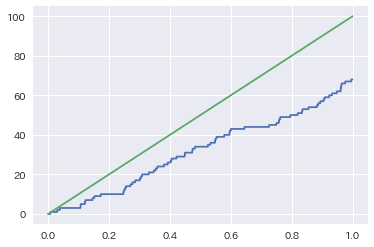

In [117]:
#最後に実施
#zxyのデイリーUU数５０万を継続した場合、どう変化していくかをシミュレーションする
#1Wなので350万impとした場合

#前提条件：
# 腕と報酬：　　　　　　　　　　　　　　CTR0.05%〜5%まで、0.05%刻みで100本の出しわけ対象バナーを用意
# imp数：　　　　　　　　　　　　　　   デイリーのUU数50万×7=350万とする
# policy_update頻度：　　　　　　　　   オンライン(デイリーバッチ対応は別途)
# impの度にバナーを何回クリックするか： 平均1のポアソン分布で代替
# 一度にいくつのバナーを表示するか：    zxyの既存の形状通り(10通り)
# 実験回数：　　　　　　　　　　　　　　350万impを100回再現させた平均を取る(※オンライン学習設定でループを回しているから時間がかかる。
# 分散でデイリー分を回すことができれば早そう)

#腕の数、time、thompsonで使うサンプリング数
get_reward, no_reward ,sums ,history_reward, history_arm,play_limit,ideal_rewards,num_reward= ts_policy(100,3500000,1000)
print(get_reward)
print(no_reward)

#報酬総数
print("報酬総数=",sum(get_reward))
#獲得可能報酬総数
print("理論限界：報酬総数=",sum(ideal_rewards))
#クリックされた回数
print("総クリック可能数",sum(play_limit))
print("表示多い数：",Counter(np.array(history_arm).flatten()).most_common(10))

import matplotlib.patches as mpatches
#報酬
plt.plot(np.linspace(0, 1, 3500000),np.cumsum(num_reward),label="actual_reward")
patch1 = mpatches.Patch(color="blue", label="actual_reward")
#理想の報酬
plt.plot(np.linspace(0, 1, 3500000),np.cumsum(ideal_rewards),label="ideal_reward")
patch2 = mpatches.Patch(color="green", label="ideal_reward")
plt.legend(handles=[patch1,patch2])
plt.title("理想的な報酬と現実報酬の差分")
plt.show()
#報酬max1%, 報酬分布の標準偏差0.001
plt.hist(np.array(history_arm).flatten(),bins=100,label="dist of played arms")
plt.title("playされたarmの分布")
plt.show()


368.0
10000.0


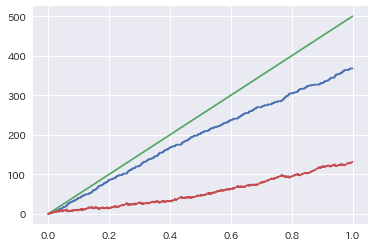

In [134]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 10000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 10000),(np.linspace(0, 1, 10000)*500))
#regret通算
plt.plot(np.linspace(0, 1, 10000), (np.linspace(0, 1, 10000)*500) - np.cumsum(history_reward) )

#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、

410.0
10000.0


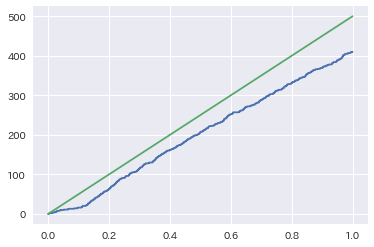

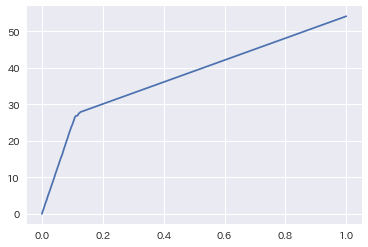

In [165]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 10000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 10000),(np.linspace(0, 1, 10000)*500))
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(10000)+0.05)-np.array(history_arm)/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 10000), cumulative_regret)
plt.show()

#み
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaは成功、失敗回数の対数を使う、初期値はそれぞれ1,0.1

361.0
10000.0


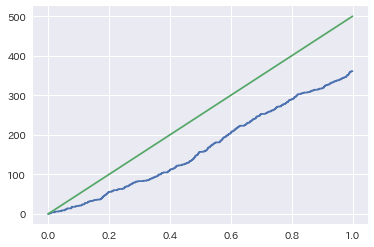

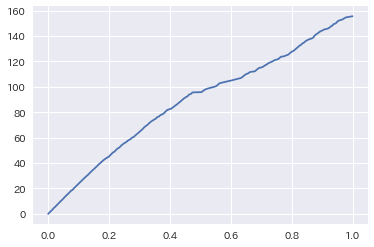

In [168]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 10000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 10000),(np.linspace(0, 1, 10000)*500))
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(10000)+0.05)-np.array(history_arm)/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 10000), cumulative_regret)
plt.show()

#み
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1

4353.0
100000.0


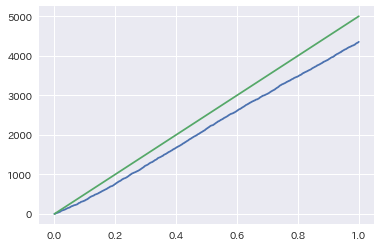

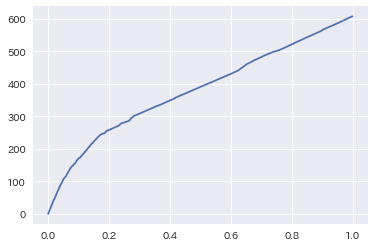

In [182]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 100000),np.cumsum(history_reward[10000:]))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 100000),(np.linspace(0, 1, 100000)*5000))
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(100000)+0.05)-np.array(history_arm[10000:])/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 100000), cumulative_regret)
plt.show()

#T=10万回でテスト
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1

(array([  4.50000000e+01,   4.50000000e+01,   4.50000000e+01,
          4.50000000e+01,   4.50000000e+01,   4.50000000e+01,
          4.50000000e+01,   4.50000000e+01,   4.50000000e+01,
          9.00000000e+01,   4.50000000e+01,   4.50000000e+01,
          6.70000000e+01,   4.50000000e+01,   1.12000000e+02,
          4.50000000e+01,   6.80000000e+01,   9.00000000e+01,
          4.50000000e+01,   4.50000000e+01,   4.50000000e+01,
          6.70000000e+01,   4.50000000e+01,   4.50000000e+01,
          4.50000000e+01,   9.00000000e+01,   4.40000000e+01,
          4.50000000e+01,   4.50000000e+01,   4.50000000e+01,
          4.50000000e+01,   1.57000000e+02,   9.00000000e+01,
          1.57000000e+02,   1.58000000e+02,   9.00000000e+01,
          4.50000000e+01,   1.35000000e+02,   4.50000000e+01,
          2.23000000e+02,   4.50000000e+01,   6.80000000e+01,
          1.13000000e+02,   4.50000000e+01,   1.13000000e+02,
          9.00000000e+01,   4.50000000e+01,   1.79000000e+02,
        

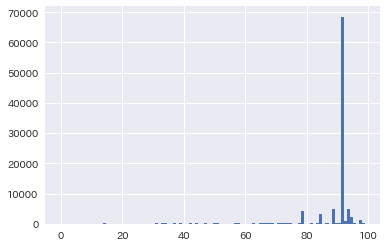

In [185]:
plt.hist(history_arm[10000:],bins=100)

365.0
10000.0


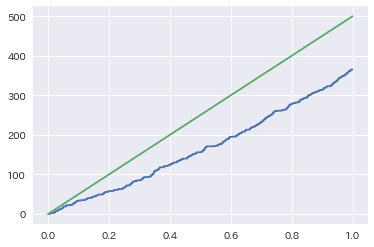

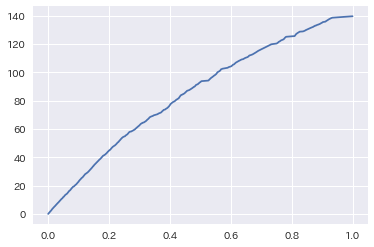

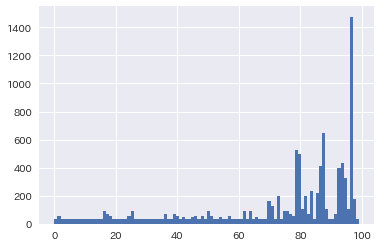

[(97, 1476), (88, 649), (79, 523)]


In [197]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 10000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 10000),(np.linspace(0, 1, 10000)*500))
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(10000)+0.05)-np.array(history_arm)/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 10000), cumulative_regret)
plt.show()

plt.hist(history_arm,bins=100)
plt.show()

#登場回数の多い３位まで
print(Counter(history_arm).most_common(3))
#alpha+beta <=1000,超えたら1000の中で按分
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1

1169.0
30000.0


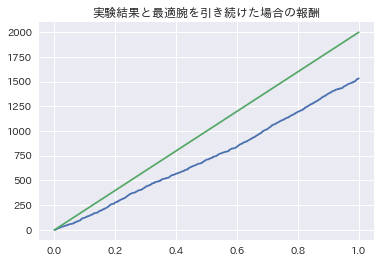

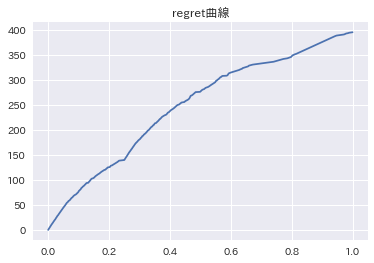

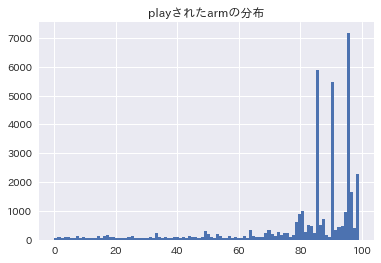

[(96, 7176), (86, 5878), (91, 5480)]


In [205]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 40000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 40000),(np.linspace(0, 1, 40000)*2000))
plt.title("実験結果と最適腕を引き続けた場合の報酬")
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(40000)+0.05)-np.array(history_arm)/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 40000), cumulative_regret)
plt.title("regret曲線")
plt.show()

plt.hist(history_arm,bins=100)
plt.title("playされたarmの分布")
plt.show()

#登場回数の多い３位まで
print(Counter(history_arm).most_common(3))
#alpha+beta <=1000,超えたら1000の中で按分
#
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1
#同じセッティングで4万イテレーション

4714.0
100000.0


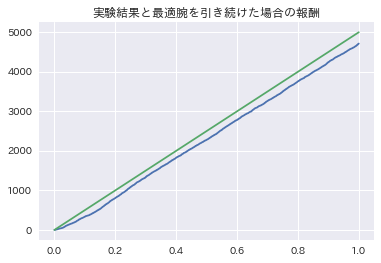

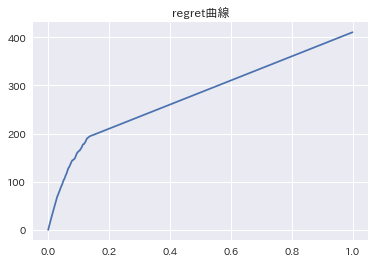

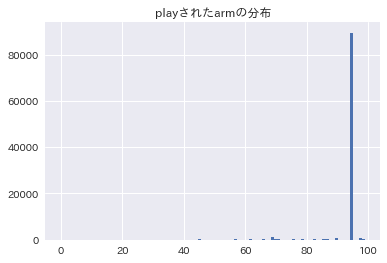

[(95, 89440), (69, 1220), (98, 981)]


In [208]:
print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 100000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 100000),(np.linspace(0, 1, 100000)*5000))
plt.title("実験結果と最適腕を引き続けた場合の報酬")
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(100000)+0.05)-np.array(history_arm)/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 100000), cumulative_regret)
plt.title("regret曲線")
plt.show()

plt.hist(history_arm,bins=100)
plt.title("playされたarmの分布")
plt.show()

#登場回数の多い３位まで
print(Counter(history_arm).most_common(3))
#alpha+beta <=1000,超えたら1000の中で按分
#
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1
#同じセッティングで10万イテレーション

In [ ]:
#腕の数、time、thompsonで使うサンプリング数
get_reward, no_reward ,sums ,history_reward, history_arm= ts_policy(100,100000,1000)
print(get_reward)
print(no_reward)
# print(sums)
# print(history_reward)
print(history_arm)

print(sum(get_reward))
print(sum(sums))

#実験結果
plt.plot(np.linspace(0, 1, 100000),np.cumsum(history_reward))
#最適腕を引き続けた場合
plt.plot(np.linspace(0, 1, 100000),(np.linspace(0, 1, 100000)*5000))
plt.title("実験結果と最適腕を引き続けた場合の報酬")
#regret
plt.show()

#regretの曲線は、history_armsを適切な値で割った数値
regret = (np.zeros(100000)+0.05)-np.array(history_arm)/2000
cumulative_regret = np.cumsum(regret)
plt.plot(np.linspace(0, 1, 100000), cumulative_regret)
plt.title("regret曲線")
plt.show()

plt.hist(history_arm,bins=100)
plt.title("playされたarmの分布")
plt.show()

#登場回数の多い３位まで
print(Counter(history_arm).most_common(3))
#alpha+beta <=1000,超えたら1000の中で按分
#
#報酬max5%, 報酬分布の標準偏差0.01 ~ 0.001、alpha,betaはそのまま成功、失敗回数を使う、初期値はそれぞれ1,0.1
#同じセッティングで10万イテレーション

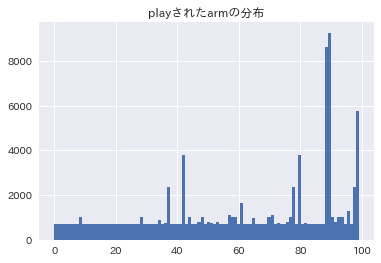

In [63]:
plt.hist(np.array(history_arm).flatten(),bins=100)
plt.title("playされたarmの分布")
plt.show()


In [67]:
im = list(range(10))
sum(im[:3])

3